In [1]:
"""
import sys
import os

parent=os.path.dirname(os.path.dirname(os.path.abspath('')))
sys.path.append(parent)
"""

import main

/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---------------------------
PATHS
---------------------------
local: /home/lachlan/CODEBASE/ReadoutXFM
data: /home/lachlan/CODEBASE/ReadoutXFM/data/example_datafile.GeoPIXE
output: /home/lachlan/CODEBASE/ReadoutXFM/data/out_example_datafile
---------------------------
---------------------------
header length: 1162 (bytes)
--------------
INDEXING
Row 70/70 at pixel 12249, byte 88726796 (100.0 %)
END OF MAP: row 70/70, pixel 12249
--------------
PARSING PIXEL DATA
Row 70/70 at pixel 12249, byte 88722712 (100.0 %)
END OF MAP: row 70/70, pixel 12249
---------------------------
COMPLETE
---------------------------
dimensions expected (x,y): 175,70
pixels expected (X*Y): 12250
pixels found: 12250
total time: 16.21 s
time per pixel: 0.001324 s
---------------------------
fitting baselines
rgb maxima: r 19329.625665704934 g 8851.258113327785 b 9717.027329310436
scaled maxima: r 1.0 g 0.4579115119146819 b 0.5027012678548974
REDUCER 1 of 2: PCA across 12250 elements
REDUCER 2 of 2: UMAP across 

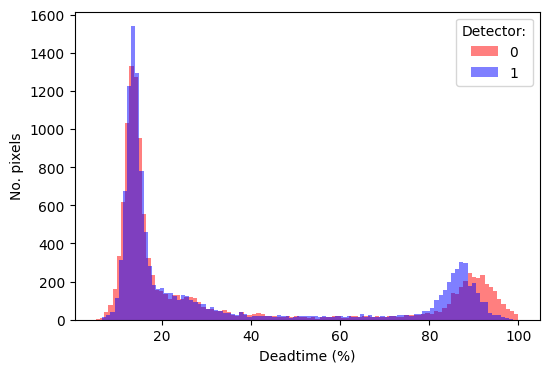

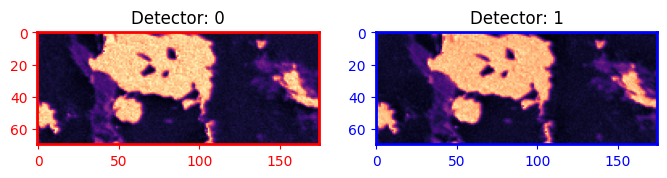

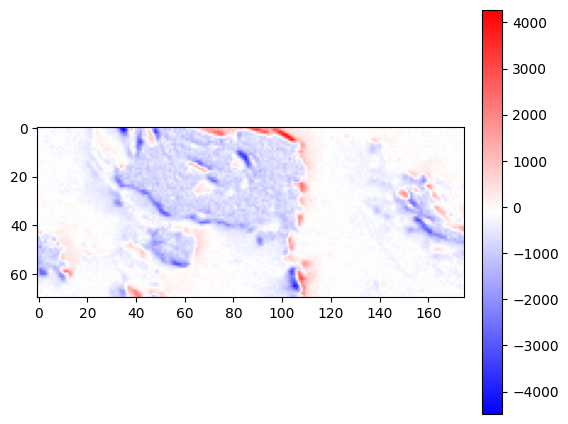

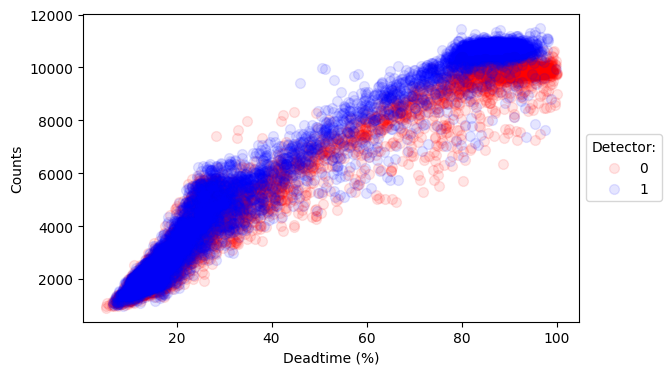

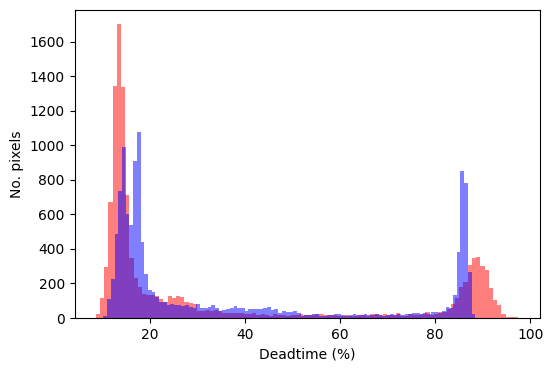

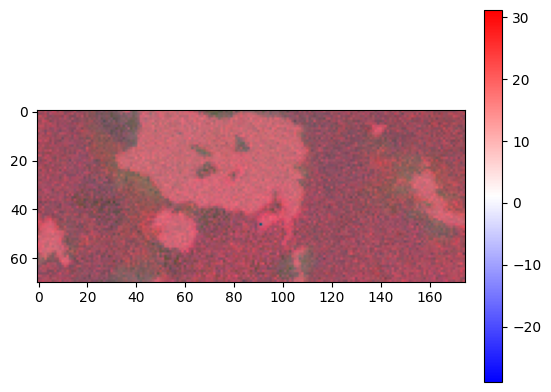

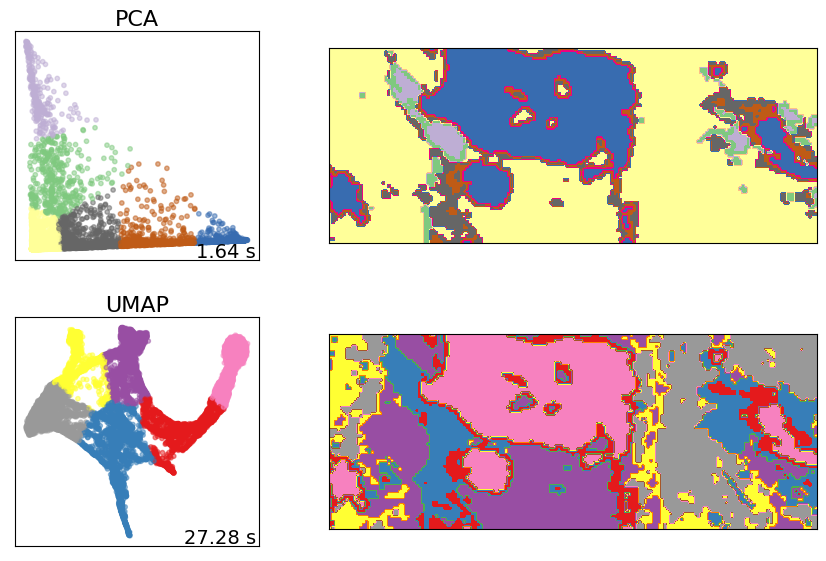

Processing complete


In [2]:
args_in = ["-f", "data/example_datafile.GeoPIXE", "-a", "-c",] 

pixelseries, xfmap = main.main(args_in)

In [10]:
import matplotlib.pyplot as plt

def plotspec(spectrum, energy):

    fig, ax1 = plt.subplots() 

    ax1.set_xlabel('energy (kV)') 
    ax1.set_ylabel('Intensity') 
    ax1.axis(xmin=0,xmax=30)

    ax1.set_yscale('log')
    
    ax1.plot(energy, spectrum, color="grey")
    
    ax1.set_ylim(bottom=0.1)
    

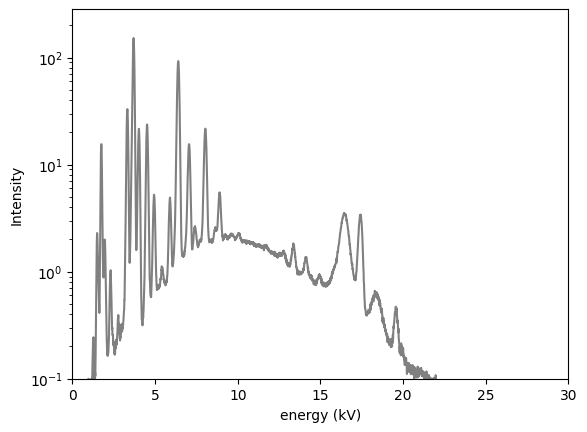

In [11]:
plotspec(pixelseries.classavg[1,1], pixelseries.energy)

In [71]:
#import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np

#nview=2044
nview=1750
vymin=-1
vymin=0

energy=pixelseries.energy
ps=pixelseries.classavg[1,1]
ps=ps/max(ps)

cred=np.zeros(pixelseries.nchan)
cgreen=np.zeros(pixelseries.nchan)
cred=np.zeros(pixelseries.nchan)

npad=pixelseries.nchan-nview

print(npad)

print(cred.shape)

hsv=cm.get_cmap('hsv',nview)


2346
(4096,)


In [98]:
cmap=hsv(range(nview))

print(cmap[600])

[0.01211339 1.         0.03827322 1.        ]


In [75]:
cmap=hsv(range(nview))
print('colarray',cmap[0,:3])    #index starts from 1 instead of 0, not sure why

cred=cmap[:,0]
cgreen=cmap[:,1]
cblue=cmap[:,2]

print(cred.shape)

cred=np.pad(cred, (0, npad), 'constant', constant_values=(0, 1))
cgreen=np.pad(cgreen, (0, npad), 'constant', constant_values=(0, 0))
cblue=np.pad(cblue, (0, npad), 'constant', constant_values=(0, 0))

print(cred.shape)

colarray [1. 0. 0.]
(1750,)
(4096,)


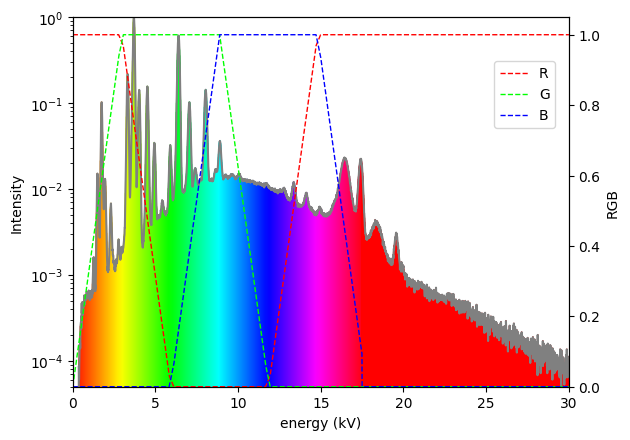

In [76]:

fig, ax1 = plt.subplots() 

ax1.set_xlabel('energy (kV)') 
ax1.set_ylabel('Intensity') 
ax1.axis(xmin=0,xmax=30)
ax1.set_yscale('log')
#ax1.axis(ymin=vymin,ymax=1)
ax1.axis(ymin=0.00005,ymax=1)

ax2 = ax1.twinx() 
ax2.set_ylabel('RGB')
ax2.axis(ymin=0,ymax=1.05)

ax2.plot(energy, cred, '#ff0000', linestyle='dashed', linewidth=1, label="R")
ax2.plot(energy, cgreen, '#00ff00', linestyle='dashed', linewidth=1, label="G")
ax2.plot(energy, cblue, '#0000ff', linestyle='dashed', linewidth=1, label="B")

ax2.legend(loc=(0.85,0.7))

ax1.plot(energy, ps, color="gray")
for i in range(len(ps) - 1):
    ax1.fill_between([energy[i], energy[i+1]], [ps[i], ps[i+1]], y2=vymin, color=(cred[i],cgreen[i],cblue[i]))


#plt.savefig(os.path.join(odir, 'hsv_spectrum.png'), dpi=150)
plt.show()